In [1]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
(X_train,Y_train),(X_test,Y_test) = mnist.load_data()
X_train = np.reshape(X_train,(60000,28,28,1)).astype('float32')
X_test = np.reshape(X_test,(10000,28,28,1)).astype('float32')
# Normalize the images between -1 to 1
X_train = (X_train - 127.5)/127.5
print(np.shape(X_train))

(60000, 28, 28, 1)


In [3]:
# Define the generator model where the input is random noise
def generator_model():
    model = Sequential()
    model.add(Dense(128*7*7,input_dim = 100, activation = LeakyReLU(0.1)))
    model.add(BatchNormalization())
    model.add(Reshape((7,7,128)))
    model.add(UpSampling2D())
    model.add(Conv2D(64,(5,5), padding = 'same', activation = LeakyReLU(0.1)))
    model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2D(1,(5,5), padding = 'same', activation = 'tanh'))
    return model

generator_model = generator_model()
print(generator_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)        0         
__________

In [4]:
# Define the discriminator model where the input is the real images from the training dataset along with the fake images from the generator
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64,(5,5),padding = 'same',input_shape = (28,28,1) , activation = LeakyReLU(0.1) , subsample = (2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128,(5,5),padding = 'same', activation = LeakyReLU(0.1) , subsample = (2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation = 'sigmoid'))
    return model

In [5]:
discriminator_model = discriminator_model() 
discriminator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile both the generator and discriminator models with the Adam optimzer
generator_model.compile(loss = 'binary_crossentropy' , optimizer = Adam())
discriminator_model.compile(loss = 'binary_crossentropy' , optimizer = Adam())

In [7]:
# Build and compile the adversarial model
generator_input = Input(shape = (100,))

generator_output = generator_model(generator_input)

discriminator_model.trainable = False

discriminator_output = discriminator_model(generator_output)

adversarial_model = Model(input = generator_input , output = discriminator_output)

adversarial_model.summary()
adversarial_model.compile(loss = 'binary_crossentropy' , optimizer = Adam())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [8]:
def train(epochs):
    batch_size = 128
    batch = 200 
    for i in range(epochs):
        for j in tqdm(range(batch)):
            # Define the noise to be input into the generator
            noise_1 = np.random.rand(batch_size,100)
            # Create the random images output from the generator
            gen_images = generator_model.predict(noise_1 , batch_size = batch_size )
            # Real images from MNIST dataset
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            # Create the input data for discriminator (real images and fake images from the generator)
            disc_inp = np.concatenate([gen_images,image_batch])
            # Assign labels where 1 is a real image and 0 is fake for the discriminator training
            disc_Y = [0]*batch_size + [1]*batch_size
            # Make discriminator model trainable
            discriminator_model.trainable = True
            # Train the discriminator model
            discriminator_model.train_on_batch(disc_inp,disc_Y)
            # Generate noise for the adversarial network
            noise_2 = np.random.rand(batch_size,100)
            # Freeze the weights of the discriminator and train the generator
            discriminator_model.trainable = False
            # Labels for adversarial model are always 1
            y_adv = [1]*batch_size
            # Train the adversarial model
            adversarial_model.train_on_batch(noise_2,y_adv)
            # Repeat process for 'epoch' no. of times

train(80)

100%|██████████| 200/200 [06:37<00:00,  1.99s/it]


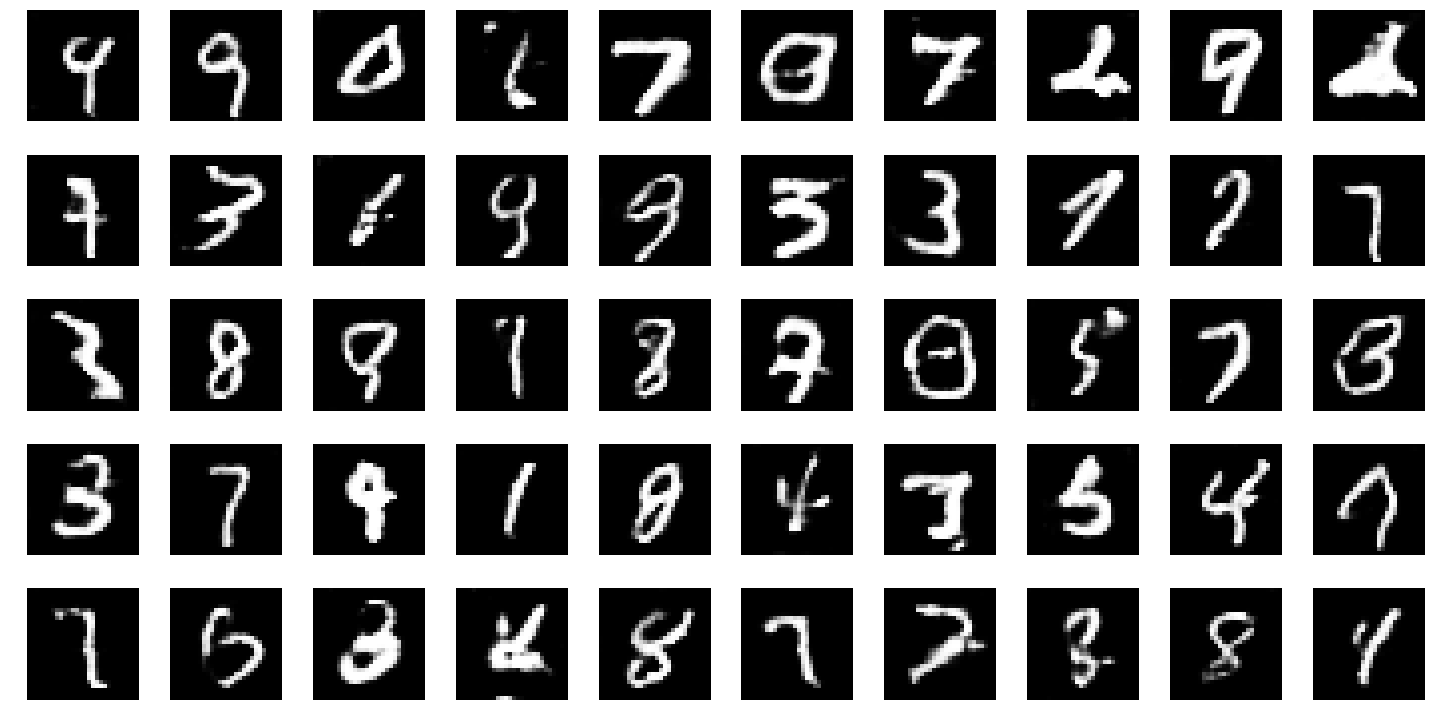

In [10]:
# Display the output of the model
import matplotlib.pyplot as plt

def plot_output(text):
    # Random noise as the input
    try_input = np.random.rand(50, 100) 
    predictions = generator_model.predict(try_input)
    plt.figure(figsize=(20,20))
    for i in range(predictions.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(text)
    
plot_output('80')    